In [1]:
# 140139281_fernando-RA_Fernando Ribeiro Aguilar.ipynb

## Objectives

Evaluate which color it is based on the RGB values. Implement a neural network from scratch and compare it's performace with pre-trained models

## Problem Description

The dataset has around 5k objects, each containing a category of color and 3 values for the pixels. The RGB values can go all the way from zero up to 255. And the combination of all of them produces a specific color.

We want to be able to classify which color it is as well as predict new colors chosen by the user

# Implementation


1. installing and importing libs

In [2]:
%pip install -q ipywidgets fastai tqdm  livelossplot

     |████████████████████████████████| 1.6 MB 5.5 MB/s 


In [3]:
import json
import urllib.request
import numpy as np
import os
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

import torch
import fastai
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from fastai.vision.all import *
from fastai.vision.augment import *
import ipywidgets as widgets



# Data Preparation


First we define a couple important functions. The first being one to remove a specific key from the json. this is used due to the fact that the dataset has uuid values which are not relevant to this problem

The second function is one of the hacks of this article. In the current vision learning approach we are using image models, which means that we need images to train and predict with. Thus, the RGB numerical values need to be first combined into an array of 32px of height and width, then, be saved into a dataset folder with it's correct labeling, and then we are able to load it using conventional image predictive functionalities.

In [4]:
def remove_uid_key(d):
    if not isinstance(d, (dict, list)):
        return d
    if isinstance(d, list):
        return [remove_uid_key(v) for v in d]
    return {k: remove_uid_key(v) for k, v in d.items()
            if k not in {'uid'}}
            
def save_image_return_url(srcFolder, label, index, r, g, b):
  target_dir = srcFolder + '/' + label
  if not(os.path.exists(target_dir)):
    mkdir(target_dir)
  img = Image.fromarray(np.full((32, 32, 3), [r, g, b], dtype = np.uint8))
  img_src = '{}/{}.jpg'.format(target_dir, index)
  img.save(img_src, mode='RGB')
  return img_src

def get_thumbnail(path):
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [5]:
response = urllib.request.urlopen("https://raw.githubusercontent.com/fernando-RA/ColorClassifer-TensorFlow.js/master/colorData.json")
data = response.read()
JSON_object = json.loads(data.decode('utf-8'))
new_json_data_without_uuid = remove_uid_key(JSON_object)
with open("colorData_training.json", 'w') as file:
    json.dump(new_json_data_without_uuid['entries'], file)


# Dataset splitting

Here we are splitting out, both training and testing dataset. Each folder with it's correct labeling substructure.

In [6]:
#training data
df = pd.read_json("colorData_training.json") 
training_folderName = 'training_data' 
os.mkdir(training_folderName)

img_arr = []
for index, row in df.iterrows():
    img_arr.append(save_image_return_url(training_folderName, row["label"], index,  row["r"], row["g"], row["b"]))
df['imageLocal'] = img_arr


In [7]:
# testing data
testing_df = df.iloc[:100].copy()
testing_folderName = 'testing_data'
os.mkdir(testing_folderName)

training_img_arr = []
for index, row in testing_df.iterrows():
    training_img_arr.append(save_image_return_url(testing_folderName, row["label"], index,  row["r"], row["g"], row["b"]))
testing_df['imageLocal'] = training_img_arr
pd.set_option('display.max_colwidth', -1)

# Constructing the Dataframe

,b,g,imageLocal,imagePILL,label,r
0,155,183,testing_data/green-ish/0.jpg,,green-ish,81
1,71,22,testing_data/pink-ish/1.jpg,,pink-ish,249
2,33,196,testing_data/orange-ish/2.jpg,,orange-ish,254
3,237,147,testing_data/blue-ish/3.jpg,,blue-ish,170
4,225,159,testing_data/blue-ish/4.jpg,,blue-ish,15
5,166,235,testing_data/green-ish/5.jpg,,green-ish,79
6,73,250,testing_data/green-ish/6.jpg,,green-ish,29
7,31,245,testing_data/green-ish/7.jpg,,green-ish,55
8,235,230,testing_data/blue-ish/8.jpg,,blue-ish,221
9,52,182,testing_data/orange-ish/9.jpg,,orange-ish,196

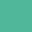
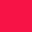
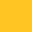
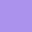
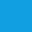
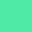
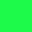
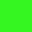
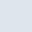
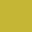
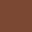
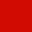
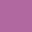
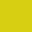
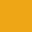
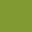
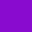
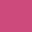
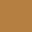
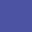
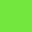
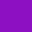
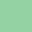
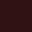
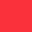
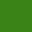
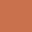
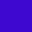
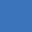
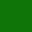
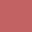
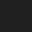
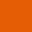
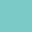
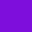
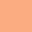
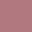
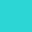
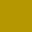
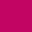
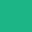
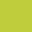
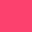
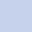
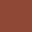
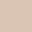
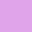
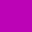
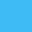
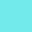
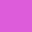
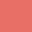
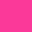
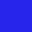
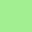
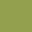
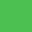
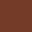
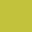
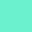
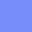
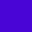
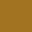
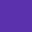
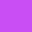
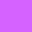
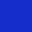
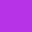
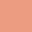
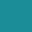
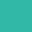
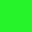
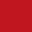
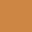
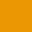
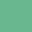
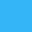
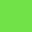
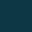
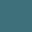
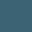
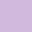
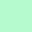
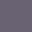
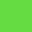
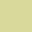
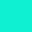
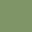
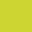
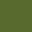
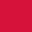
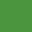
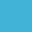
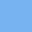
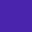
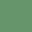
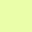
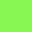
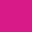
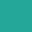

In [9]:
df['imagePILL'] = df.imageLocal.map(lambda f: get_thumbnail(f))
testing_df['imagePILL'] = testing_df.imageLocal.map(lambda f: get_thumbnail(f))

testing_df= testing_df.reindex(sorted(testing_df.columns), axis=1)
HTML(testing_df.to_html(formatters={'imagePILL': image_formatter}, escape=False))


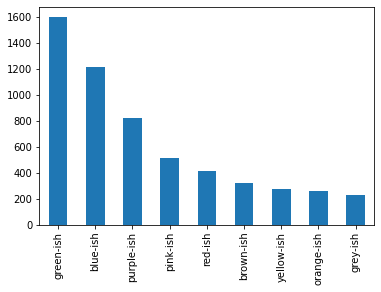

In [10]:
df['label'].value_counts().plot.bar()

# Constructing the Datablock from the Dataframe

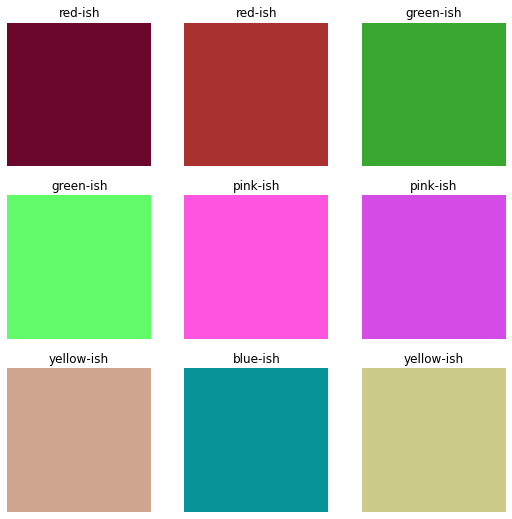

In [40]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.1, seed=42),
                   get_x=ColReader('imageLocal'),
                   get_y=ColReader('label'),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = db.dataloaders(df)
dls.show_batch()

# Training the vision_learner fast ai model

In [12]:
learn = vision_learner(dls, resnet18, metrics=accuracy, normalize=True)
learn.fine_tune(4)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.586150,0.914395,0.744681,00:21


epoch,train_loss,valid_loss,accuracy,time
0,1.168557,0.923932,0.746454,00:20
1,1.113812,0.812183,0.757092,00:21
2,0.975235,0.720511,0.785461,00:20
3,0.906571,0.710559,0.787234,00:20


# Training the CNN fast ai model

In [42]:
learnCNN = cnn_learner(dls, resnet34, metrics=accuracy)


SuggestedLRs(valley=0.0014454397605732083)

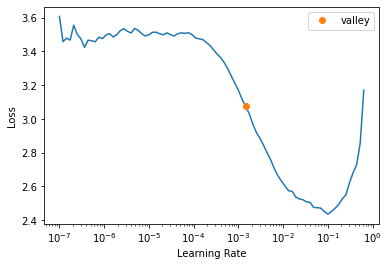

In [43]:
learnCNN.lr_find()


epoch,train_loss,valid_loss,accuracy,time
0,1.489691,1.203011,0.695035,00:21


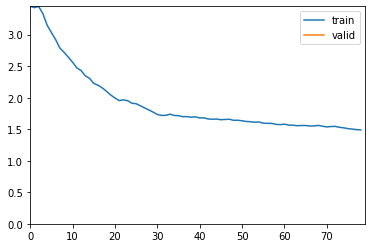

epoch,train_loss,valid_loss,accuracy,time
0,1.044732,0.822673,0.780142,00:27
1,0.954737,0.781157,0.744681,00:27
2,0.954710,1.089692,0.750000,00:27
3,0.940662,0.819690,0.773050,00:28
4,0.910107,0.978015,0.774823,00:27
5,0.871953,0.705970,0.771277,00:28
6,0.841538,0.679620,0.787234,00:28
7,0.820013,0.699398,0.794326,00:27
8,0.778373,0.654667,0.789007,00:28
9,0.787307,0.662975,0.789007,00:28


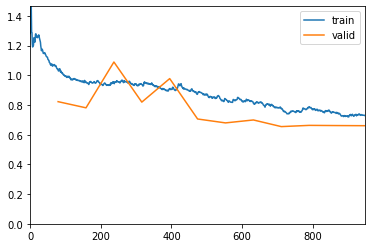

In [47]:
learnCNN.fine_tune(12, base_lr=1e-2, cbs=[ShowGraphCallback()])

In [48]:
learnCNN.export("models/fastai-vision.pkl")

In [49]:
interp = ClassificationInterpretation.from_learner(learnCNN)


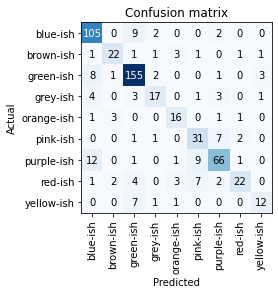

In [50]:
interp.plot_confusion_matrix()


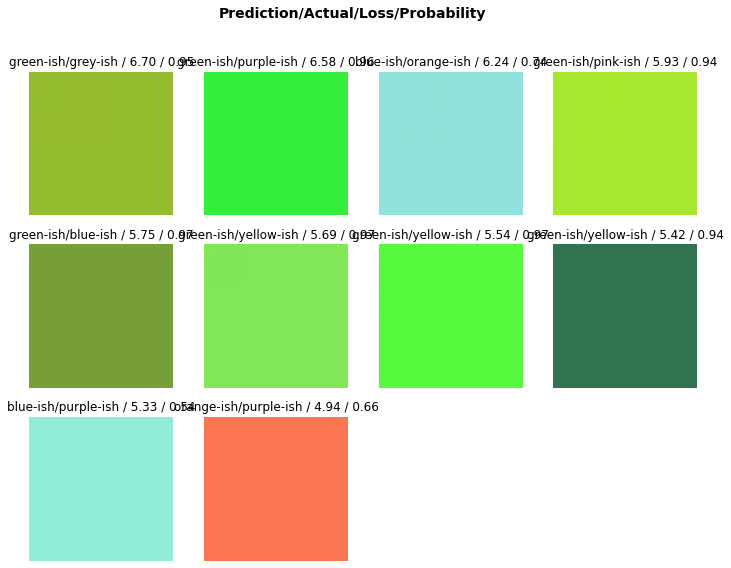

In [51]:
interp.plot_top_losses(10)


# Training a RNN, the pytorch way


### Data preparation

Making pytorch datasets

Below are the transformations we will make to each of the images when creating our Pytorch datasets.



In [52]:

from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
from livelossplot import PlotLosses


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)
full_dataset = torchvision.datasets.ImageFolder(Path(training_folderName).as_posix(), transform = transform)
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])
testing_set = torchvision.datasets.ImageFolder(Path(testing_folderName).as_posix(), transform = transform)


We just built 3 datasets. 

A training dataset, a validation dataset and a testing dataset.

In [53]:
batchSize = 64
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batchSize, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batchSize)
dataloaders = {
    "train": train_loader,
    "validation": validation_loader
}

# Training a neural network

Using Pytorch, we will only include linear layers with some non-linearity between them.


In [54]:

pytorch_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 128),
    nn.ReLU(),
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.LogSoftmax(dim=1))

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 1e-2
nb_epoch = 77

In [56]:
optimizer = torch.optim.SGD(pytorch_net.parameters(), lr=lr)
criterion = nn.NLLLoss()


In [57]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    liveloss = PlotLosses() # Live training plot generic API
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    
    for epoch in range(num_epochs): # Number of passes through the entire training & validation datasets
        logs = {}
        for phase in ['train', 'validation']: # First train, then validate
            if phase == 'train':
                model.train() # Set the module in training mode
            else:
                model.eval() # Set the module in evaluation mode

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # count of carrectly classified inputs

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Perform Tensor device conversion
                labels = labels.to(device)

                outputs = model(inputs) # forward pass through network
                loss = criterion(outputs, labels) # Calculate loss

                if phase == 'train':
                    optimizer.zero_grad() # Set all previously calculated gradients to 0
                    loss.backward() # Calculate gradients
                    optimizer.step() # Step on the weights using those gradient w -=  gradient(w) * lr

                _, preds = torch.max(outputs, 1) # Get model's predictions
                running_loss += loss.detach() * inputs.size(0) # multiply mean loss by the number of elements
                running_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # get the "mean" loss for the epoch
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset) # Get proportion of correct predictions
            
            # Logging
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs) # Update logs
        liveloss.send() # draw, display stuff

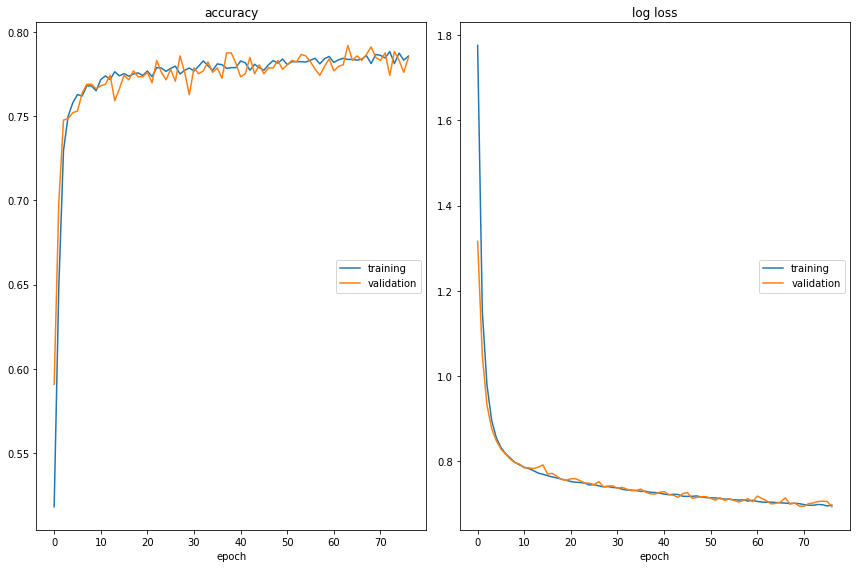

accuracy
	training         	 (min:    0.518, max:    0.788, cur:    0.786)
	validation       	 (min:    0.591, max:    0.792, cur:    0.785)
log loss
	training         	 (min:    0.695, max:    1.776, cur:    0.697)
	validation       	 (min:    0.693, max:    1.316, cur:    0.693)


In [58]:
train_model(pytorch_net, criterion, optimizer, dataloaders, nb_epoch)

In [59]:
torch.save(pytorch_net, 'models/pytorch-acc.pt')

# Evaluating our model's inference on the testing dataset!


In [60]:


def test_model(model, criterion, test_loader):
    model = model.to(device)
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
         
            _, preds = torch.max(outputs, 1)
        
            test_loss += loss * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
    
        avg_loss = test_loss / len(test_loader.dataset)
        avg_acc = test_corrects.float() / len(test_loader.dataset)
    
    return avg_loss.item(), avg_acc.item()

In [61]:
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batchSize)


In [62]:
pytorch_loss, pytorch_accuracy = test_model(pytorch_net, criterion, testing_loader)


In [63]:
def print_loss_acc(loss, acc):
    print("Loss : {:.6f}".format(loss))
    print("Accuracy : {:.6f}".format(acc))

In [64]:
print_loss_acc(pytorch_loss, pytorch_accuracy)

Loss : 1.004436
Accuracy : 0.640000


In [74]:

learn = load_learner('models/fastai-vision.pkl')

# Predicting based on user's input

choose any value iin the slider and you will get a new prediction

In [84]:
r=widgets.IntSlider(min=0, max=255, value=0, step=1,description="R:")
g=widgets.IntSlider(min=0, max=255, value=0, step=1,description="G:")
b=widgets.IntSlider(min=0, max=255, value=0, step=1,description="B:")

index_to_label = df.to_dict()['label']

def predict(r,g,b):
    user_input_img = Image.fromarray(np.full((32, 32, 3), [r, g, b], dtype = np.uint8))
    display(user_input_img)
    tensor = transform(user_input_img).unsqueeze(0).to(device)
    output = pytorch_net.forward(tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print('label:{}, confidence: {:.2f}'.format(index_to_label[classes.item()], conf.item()))

ui = widgets.HBox([r,g,b])

out = widgets.interactive_output(predict, {'r': r, 'g': g, 'b': b})
display(out, ui)


Output()